In [ ]:
#pip inatall pmdarima

# 0. Import Libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from itertools import product
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
import os
import re

### Gathering Data

In [109]:
def get_datasets(f_list):
    for file in f_list:
        file_name, file_type = file.split(".")
        file_name = re.sub('[^A-Za-z0-9]+','',file_name)
        f_path = path+'\\'+file
        #print(f_path)
        if (file_name == 'CoreCPIFood') or (file_name == 'CoreCPIFuel') or (file_name == 'CoreCPIHousing') or ('CPI' in file_name):            
            globals()[file_name] = pd.read_excel(f_path, index_col = 0)
        elif ('GDP' in file_name):
            globals()[file_name] = pd.read_excel(f_path, names=['DATE', 'GDP'], index_col='DATE', parse_dates=True)
        elif ('DSPIC' in file_name):
            globals()[file_name] = pd.read_excel(f_path, names=['DATE', 'DSPIC'], index_col='DATE', parse_dates=True)
        elif file_name =='interestrates':
            globals()[file_name] = pd.read_excel(f_path, names=['DATE', 'FEDINT'], index_col='DATE', skiprows=[0], parse_dates=True)
        elif ('NASDAQ' in file_name):
            globals()[file_name] = pd.read_excel(f_path, names=['DATE', 'NASDAQ'], index_col='DATE', skiprows=[0], parse_dates=True)
        elif ('PCE' in file_name):
            globals()[file_name] = pd.read_excel(f_path, names=['DATE', 'PCE'], index_col='DATE', skiprows=[0], parse_dates=True)
        elif ('popul' in file_name):
            globals()[file_name] = pd.read_excel(f_path, names=['DATE', 'POPUL'], index_col='DATE', skiprows=[0], parse_dates=True) 
        else:
            globals()[file_name] = pd.read_excel(f_path, index_col=0)
        o_table_names.append(file_name)    
        
        #print(file_name)
        #display(globals()[file_name].head(5))
        #print("\n\n\n")

In [110]:
path = "C:\\Users\\singg\\Desktop\\6050\\Interest Rates\\data"
file_list = os.listdir(path)
#print(file_list)

### Converting Dataset

In [111]:
def t_naming(table_names):
    for tn in table_names:
        globals()[tn].name = tn
        #print(globals()[tn].name)

In [112]:
def convert_dataframes(o_df):
 
    date = []
    values = []
    n_index = []

    for ind in o_df.index:
        for c in o_df.columns:
            t_n = c+'/'+str(ind)
            #t_n = time.strptime(t_n, f)
            t_cpi = o_df.loc[ind][c]
            date.append(t_n)
            values.append(t_cpi)
                
    date = pd.Series(date)
    values = pd.Series(values)
     
    t = {o_df.name : values}
    t2 = pd.DataFrame(t)

    globals()[o_df.name] = t2 
    globals()[o_df.name].index = date
    globals()[o_df.name].index = pd.to_datetime(globals()[o_df.name].index)
  


In [113]:
def print_tables(tablelists):
    for tn in tablelists:
        print(tn, end= '\t')
        print(globals()[tn].shape)
        display(globals()[tn].head())
        print("\n\n")

In [114]:
def adjusting_period(table):
    table = table[table.index>'1991-12-31']
    table = table[table.index<'2023-5-01']
    table.dropna(inplace=True)
    return table

In [115]:
def converting_nasdaq(table):
    count = 0
    index = []
    m_avg = []
    m_total = []
    month = table.index.month[0]
    year = list(set(table.index.year))
    count_y =0
    for i in range(len(table)):
        if month == table.index.month[i]:
            count += 1
            m_total.append(table.iloc[i][0]) 
            if i+1 == len(table):
                index.append(str(year[count_y])+'/'+str(month))
                month = table.index.month[i]
                ta = round(sum(m_total)/count,3)
                m_avg.append(ta)
        else:
            #print('year', year[count_y])
            #print('m_total',m_total)
            #print('count_y', count_y)
            index.append(str(year[count_y])+'/'+str(month))
            if month == 12:
                count_y += 1
            month = table.index.month[i]
            ta = round(sum(m_total)/count,3)
            m_avg.append(ta)
            m_total = []
            count = 0
            #print(m_avg,"\n")

    #print(index)
    #print('m_avg', m_avg)
    table = pd.DataFrame(list(zip(index,m_avg)), columns=['DATE', 'NASDAQ']).set_index('DATE')
    table.index = pd.to_datetime(table.index)
    globals()['NASDAQ'] = table

    
    return table

### Integrate Dataset

In [116]:
def integrate_df():
    df = pd.DataFrame()

    for i, t in enumerate(o_table_names):
        if i == 0:
            df = globals()[t]
        else:
            df = df.join(globals()[t])
    return df

# 1. Preprocessing

In [117]:
def df_preprocessing():
    #loading datasets from local files
    get_datasets(file_list)
    
    #naming Tables
    t_naming(o_table_names)
    
    #converting tables from a format with a year index and month columns 
    #to a format with a datetime index (year-month-1st day) and columns identifying their figures (for example GDP).
    c_table_names = ['CoreCPIFood', 'CoreCPIFuel', 'CoreCPIHousing', 'CPI19901999', 'CPI20002023','UnemploymentRates']
    for tn in c_table_names:
        convert_dataframes(globals()[tn])
     
    #nameing Tables
    t_naming(o_table_names)
    
    #combining 2 tables of CPI with data for different time periods into a table 
    CPI19901999.rename(columns={'CPI19901999': 'CPI'}, inplace=True)
    CPI20002023.rename(columns={'CPI20002023': 'CPI'}, inplace=True)
    o_table_names.remove('CPI19901999')
    o_table_names.remove('CPI20002023')
    globals()['CPI'] = pd.concat([CPI19901999, CPI20002023])
    o_table_names.append('CPI')
    
    
    #adjusting Period
    for tn in o_table_names:
        globals()[tn] = adjusting_period(globals()[tn])   
        
    #Converting data in NASDAQ table from daily to monthly ones by calculating its average value for each month
    NASDAQ = converting_nasdaq(globals()['NASDAQ'])
    
    df = integrate_df()

    return df

In [118]:
#======lists of tables' names
o_table_names = []
    
        
#======loading datasets from local files, converting tables from a format with a year index and month columns, 
#combining 2 tables of CPI with data for different time periods into a table, adjusting Period, 
#and converting data in NASDAQ table from daily to monthly ones by calculating its average value for each month
df = pd.DataFrame()
df = df_preprocessing()
    
print("Integrated Dataset : ", df.shape)
display(df.head())
print("\n\n")
    
c_df = df.copy()
f_df = c_df.drop('NASDAQ', axis=1, inplace=False)
l_df = c_df['NASDAQ']
    
train = l_df[:352]
test = l_df[352:]
df.index.freq = 'MS'
train.index.freq = 'MS'
test.index.freq = 'MS'

Integrated Dataset :  (376, 11)


,CoreCPIFood,CoreCPIFuel,CoreCPIHousing,DSPIC,GDP,FEDINT,NASDAQ,PCE,POPUL,UnemploymentRates,CPI
1992-01-01,136.6,116.5,135.9,7065.3,9485.744310,255331,615.734,4084.7,255331,7.3,138.3
1992-02-01,137.1,116.4,136.1,7097.8,9528.065649,255576,632.527,4099.5,255576,7.4,138.6
1992-03-01,137.6,116.4,136.4,7105.5,9606.295398,255848,618.843,4117.0,255848,7.4,139.1
1992-04-01,137.5,117.0,136.7,7126.8,9612.353987,256139,581.825,4131.5,256139,7.4,139.4
1992-05-01,137.2,117.3,136.9,7161.1,9594.439993,256437,581.648,4158.4,256437,7.6,139.7


# 2. Explorting Data

### Time Series Plots 

In [119]:
def plot_features(f_df,df):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18,18))

    for i, ax in enumerate(axes.flat):
        d = f_df[f_df.columns[i]]
        ax.plot(d)
        ax2 = ax.twinx()  
        ax2.plot(df['NASDAQ'], color ='black')
        ax2.set_ylim(400, 15000)        
        ax.set_title(f_df.columns[i])

Plots for Time Series


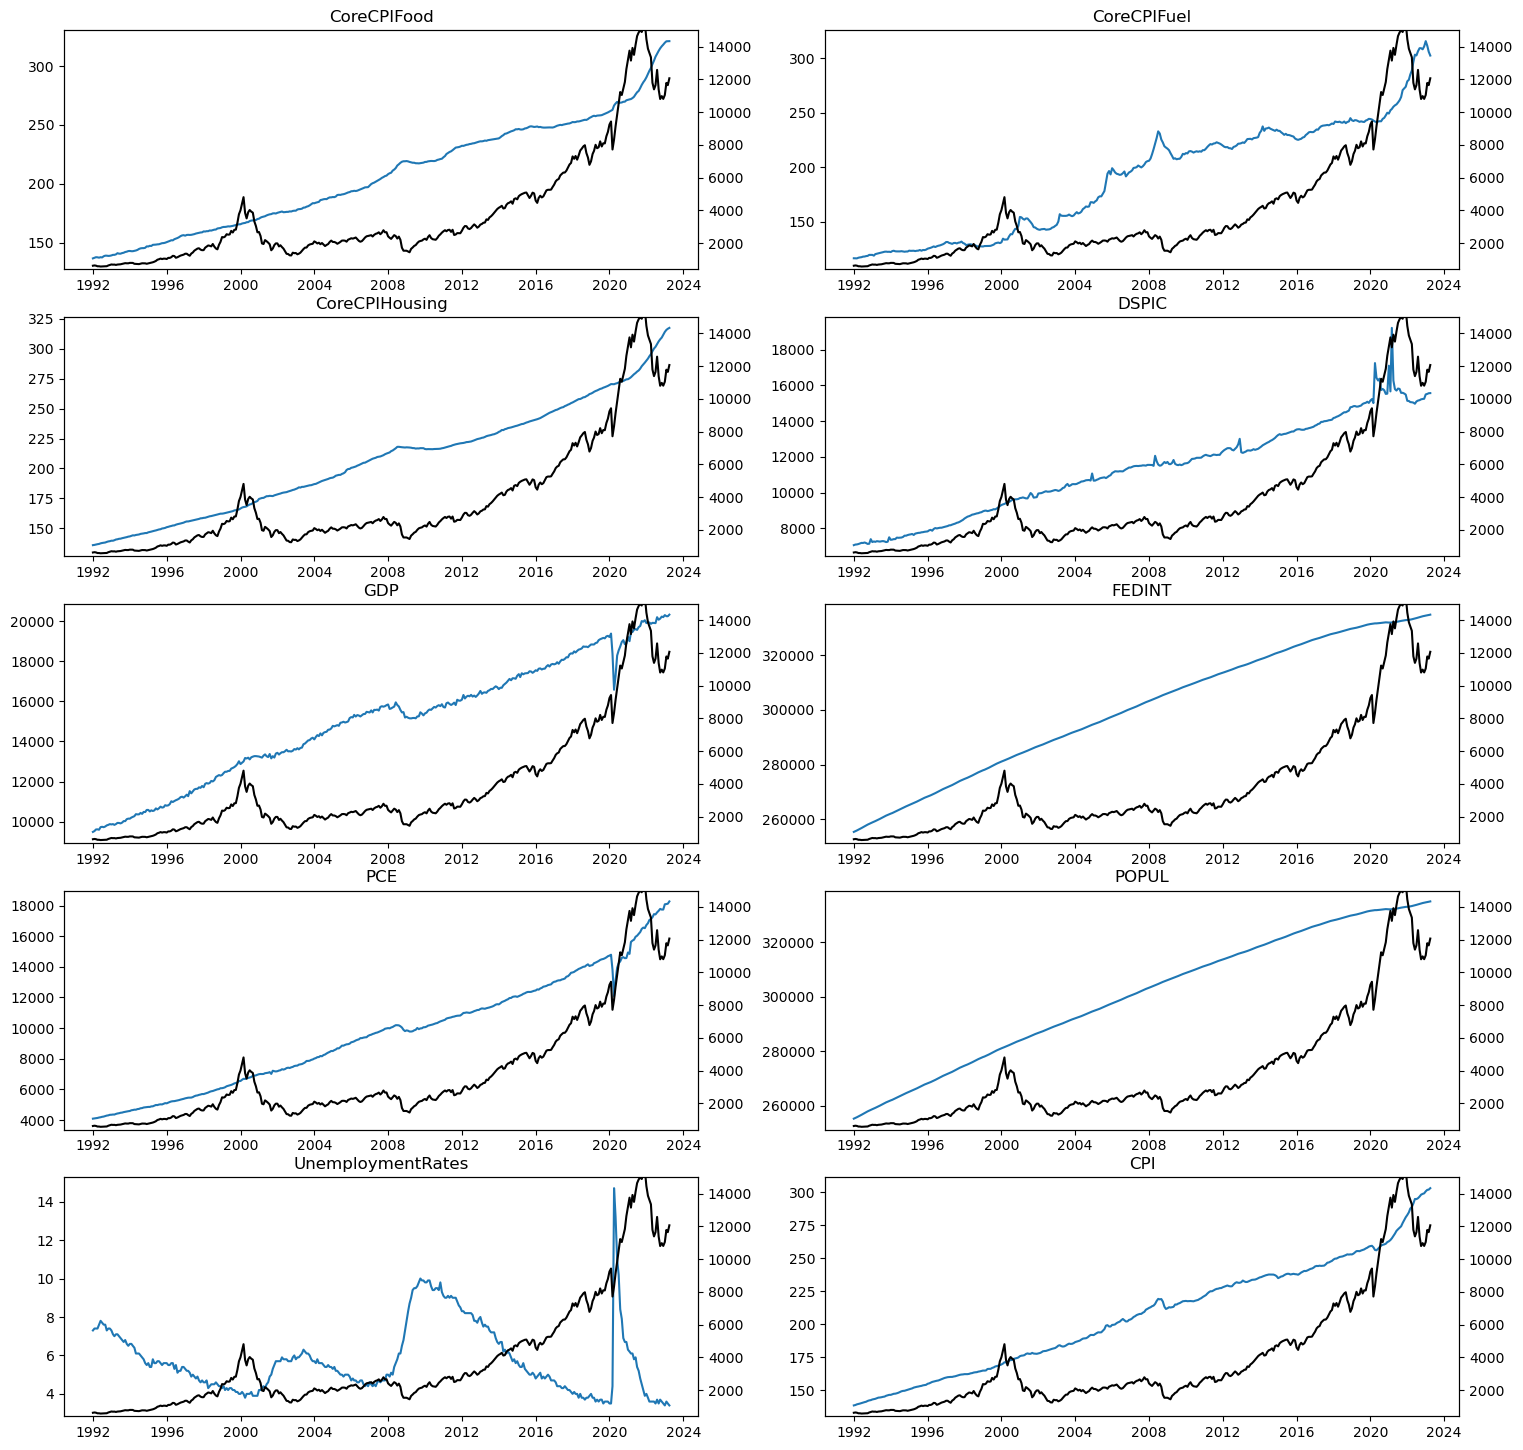

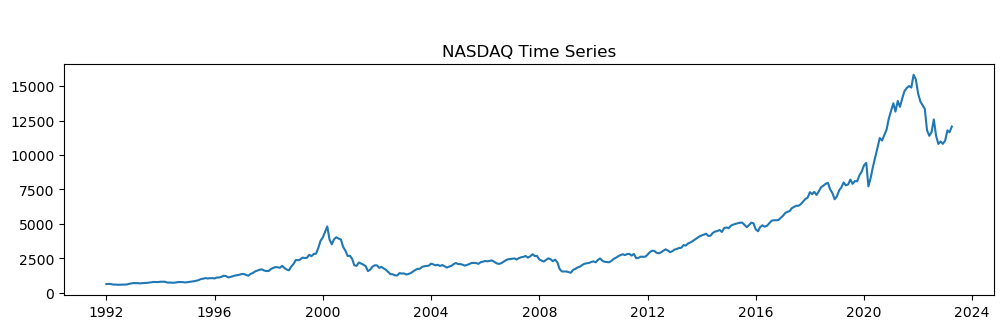

In [120]:
print("Plots for Time Series")
plot_features(f_df, c_df)
    
plt.figure(figsize=(12,3))
plt.title('\n\nNASDAQ Time Series')
plt.plot(df['NASDAQ'])

### Decomposition

In [121]:
def decompose_ts(df):
    decompose = seasonal_decompose(df['NASDAQ'])

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

    ax1.set_title('\n\nDecompostion')
    ax1.plot(decompose.observed)
    ax1.set_ylabel('Observed')
 
    ax2.plot(decompose.trend)
    ax2.set_ylabel('Trend')
 
    ax3.plot(decompose.seasonal)
    ax3.set_ylabel('Seasonal')
 
    ax4.plot(decompose.resid)
    ax4.set_ylabel('Residuals')
    
    plt.figure(figsize= (9,2))
    plt.plot(decompose.seasonal[0:36])
    plt.title('Seasonality in 3 years')


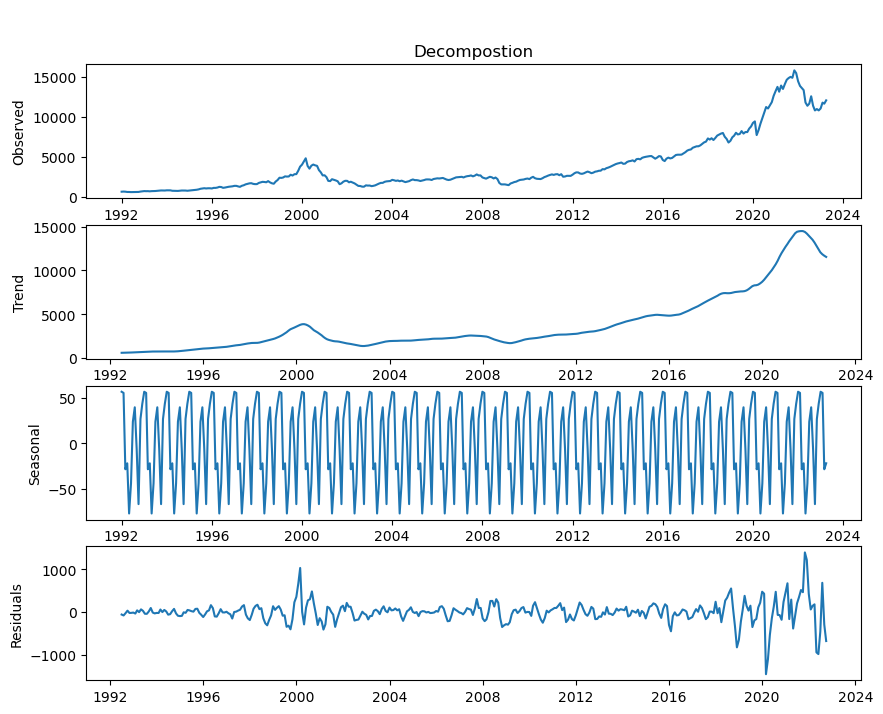

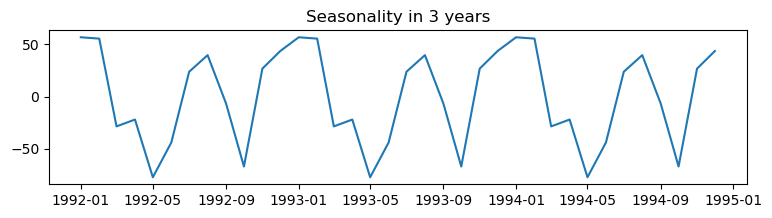

In [122]:
#Checking Components of Time Series
decompose_ts(c_df)

### Check Stationarity : Agumented Dickey Fuller 

In [123]:
def check_stationability(s):
    adf_result = adfuller(s)
    print("ADF Statistic: ", adf_result[0])
    print("p-value: ",  adf_result[1])
    
    if (adf_result[0]>0) or (adf_result[1]>0.05):
        print("Non Stationary Data")
    else:
        print("Stationary Data")

In [124]:
check_stationability(c_df['NASDAQ'])

ADF Statistic:  0.9807338024217997
p-value:  0.9940584505042853
Non Stationary Data


### Converting to Stationary Time Series

In [125]:
def convert_StationaryTS(s, n):
    diff_s = np.diff(df['NASDAQ'], n=n)
    check_stationability(diff_s)
    return diff_s

In [126]:
diff1 = convert_StationaryTS(df['NASDAQ'], n=1)
diff12 = convert_StationaryTS(df['NASDAQ'], n=12)
diff1_12 = convert_StationaryTS(diff1, n=12)

ADF Statistic:  -5.920691792184746
p-value:  2.5106539640794484e-07
Stationary Data
ADF Statistic:  -18.639372771533104
p-value:  2.054642411252782e-30
Stationary Data
ADF Statistic:  -18.639372771533104
p-value:  2.054642411252782e-30
Stationary Data


### ACF PACF Plots

In [127]:
def plot_corrlation(s, lags):
    plot_acf(s, lags=lags);
    plt.tight_layout()
    
    plot_pacf(s, lags=lags);
    plt.tight_layout()

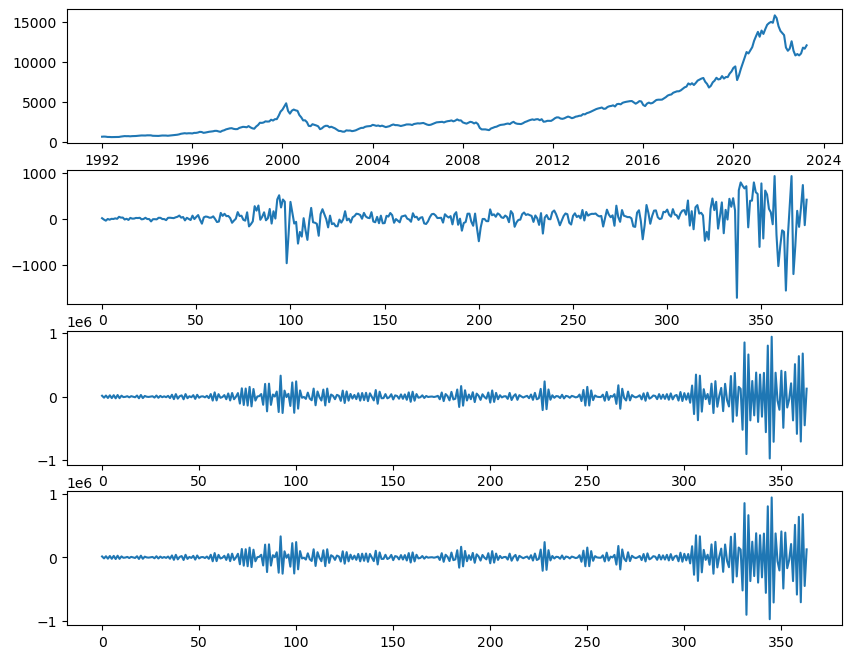

In [128]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))
ax[0].plot(df['NASDAQ'])
ax[1].plot(diff1)
ax[2].plot(diff12)
ax[3].plot(diff1_12)

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


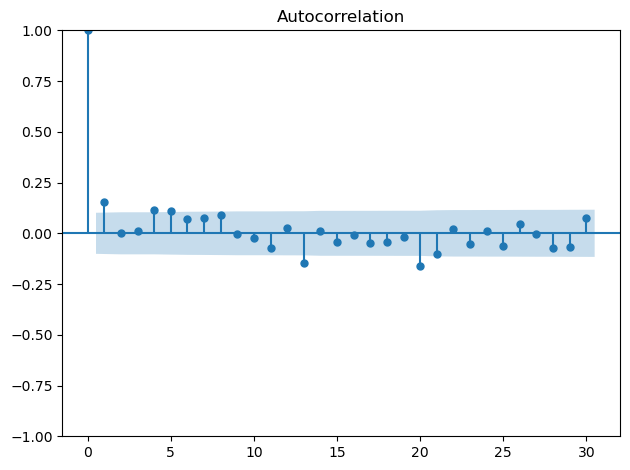

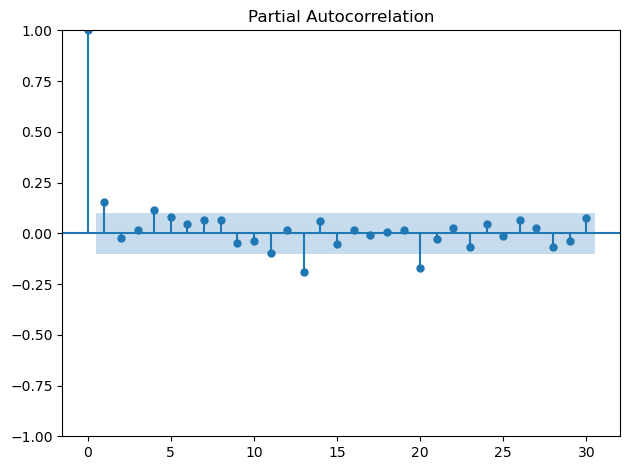

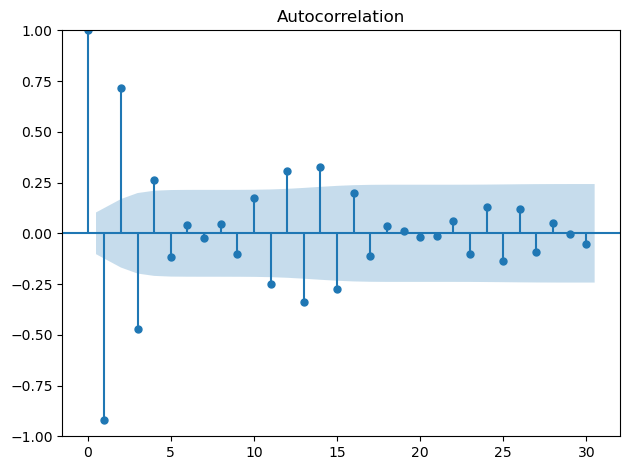

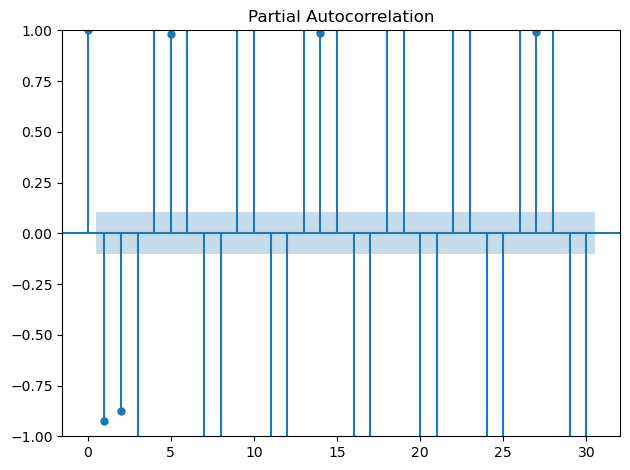

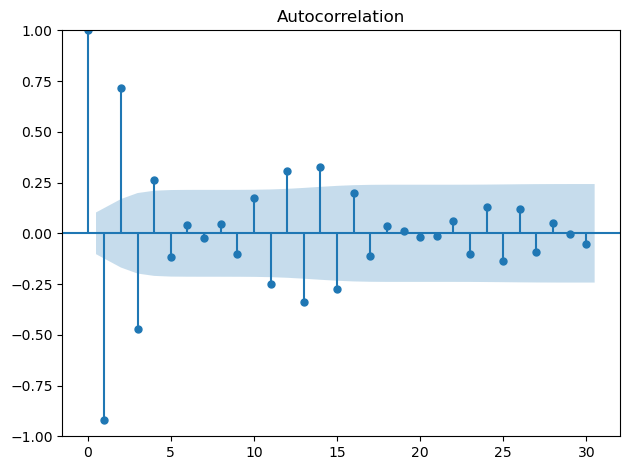

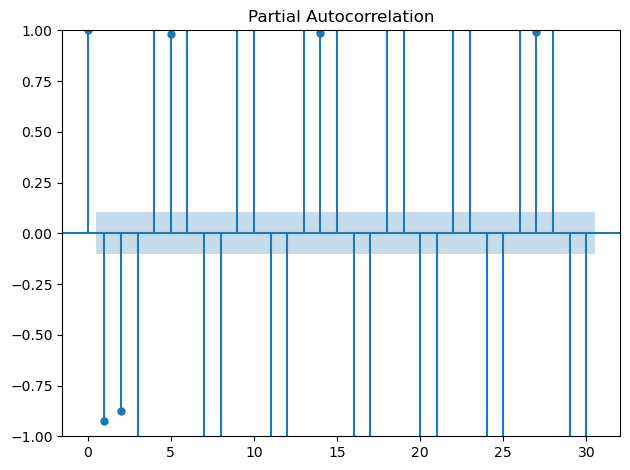

In [129]:
plot_corrlation(diff1, 30)
plot_corrlation(diff12, 30)
plot_corrlation(diff1_12, 30)

### Selecting Parameters based on AIC

In [130]:
def SARMIA_M(endog : Union[pd.Series, list], order, d, D, s):
    result = []
    
    for od in tqdm_notebook(order):
        
        #print('od',od)
        try: 
            model =SARIMAX(endog, 
                           order= (od[0], d, od[1]), 
                           seasonal_order=(od[2], D, od[3], s),           
                           simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        #print('aic',aic)
        t = (od[0], d, od[1], od[2], D, od[3])
        result.append([t, aic])
    result_df = pd.DataFrame(result, columns=['(p,d,q,P,D,Q)', 'AIC'])
    result_df = result_df.sort_values(by = 'AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Training Models

In [131]:
def train_models(df, order, seasonal_order):
    model = SARIMAX(train, order = order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    return model_fit

### Examining Residuals

In [132]:
def check_residuals(model_fit):
    model_fit.plot_diagnostics(figsize = (10,8));
    residuals = model_fit.resid
    result_ljb_model = acorr_ljungbox(residuals, np.arange(1,12,1))
    print(result_ljb_model)

In [133]:
#Selecting parameters based on model AIC
p = range(0,3,1)
q = range(0,3,1)
P = range(0,3,1)
Q = range(0,3,1)
s = 12    
orders = list(product(p, q, P, Q))

C:\Users\singg\AppData\Local\Temp\ipykernel_41240\796591091.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for od in tqdm_notebook(order):


  0%|          | 0/81 [00:00<?, ?it/s]

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\singg\anaconda3\lib\site-packa

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\singg\anaconda3\lib\site-packa

        (p,d,q,P,D,Q)          AIC
0  (1, 1, 2, 0, 0, 1)  4750.778047
1  (1, 1, 2, 1, 0, 0)  4750.915757
2  (1, 1, 2, 0, 0, 0)  4751.511058
3  (2, 1, 1, 0, 0, 0)  4751.972042
4  (1, 1, 2, 2, 0, 0)  4752.493993
5  (1, 1, 2, 0, 0, 2)  4752.677132
6  (1, 1, 2, 1, 0, 1)  4752.886304
7  (1, 1, 2, 2, 0, 2)  4753.176592
8  (1, 1, 2, 2, 0, 1)  4753.387835
9  (1, 1, 2, 1, 0, 2)  4753.678578
      lb_stat  lb_pvalue
1    0.027847   0.867470
2    0.712773   0.700202
3    1.759601   0.623765
4    3.033646   0.552211
5    3.045241   0.693011
6   13.902577   0.030744
7   15.014529   0.035814
8   16.713305   0.033237
9   18.118915   0.033819
10  19.502569   0.034325
11  21.159529   0.031755


C:\Users\singg\AppData\Local\Temp\ipykernel_41240\796591091.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for od in tqdm_notebook(order):


  0%|          | 0/81 [00:00<?, ?it/s]

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

        (p,d,q,P,D,Q)          AIC
0  (1, 1, 2, 0, 1, 1)  4624.106558
1  (2, 1, 1, 0, 1, 1)  4624.456142
2  (0, 1, 1, 0, 1, 1)  4624.812175
3  (1, 1, 0, 0, 1, 1)  4624.992826
4  (2, 1, 1, 0, 1, 2)  4625.344379
5  (2, 1, 1, 1, 1, 1)  4625.362494
6  (1, 1, 2, 1, 1, 1)  4625.628882
7  (1, 1, 2, 0, 1, 2)  4625.686058
8  (0, 1, 1, 0, 1, 2)  4626.050019
9  (0, 1, 1, 1, 1, 1)  4626.070970
      lb_stat  lb_pvalue
1    0.140877   0.707411
2    0.867737   0.647998
3    1.471161   0.688942
4    3.096377   0.541829
5    4.212645   0.519224
6   11.618509   0.071041
7   13.653467   0.057699
8   15.514709   0.049877
9   16.034741   0.066160
10  17.692575   0.060376
11  18.197351   0.077113


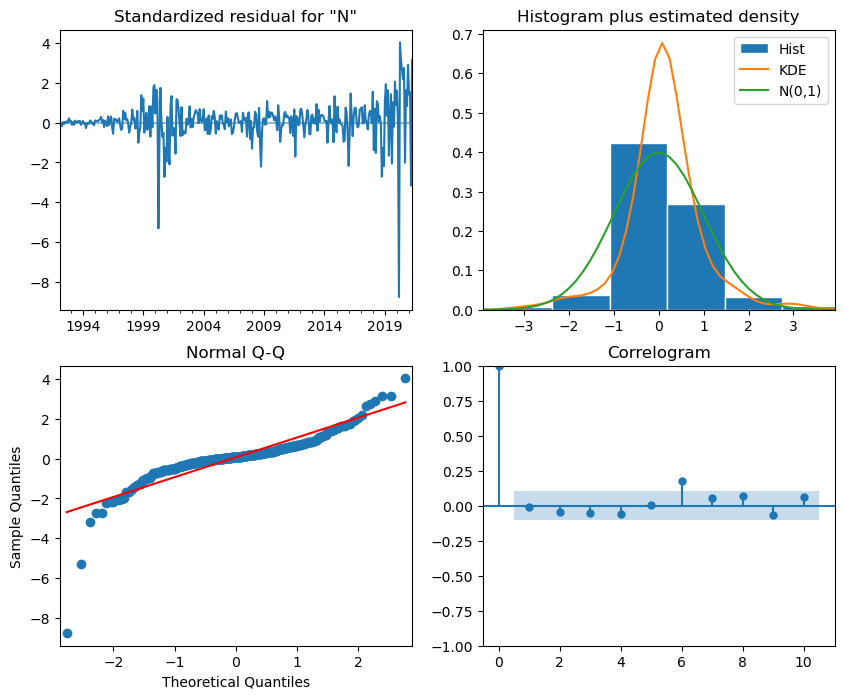

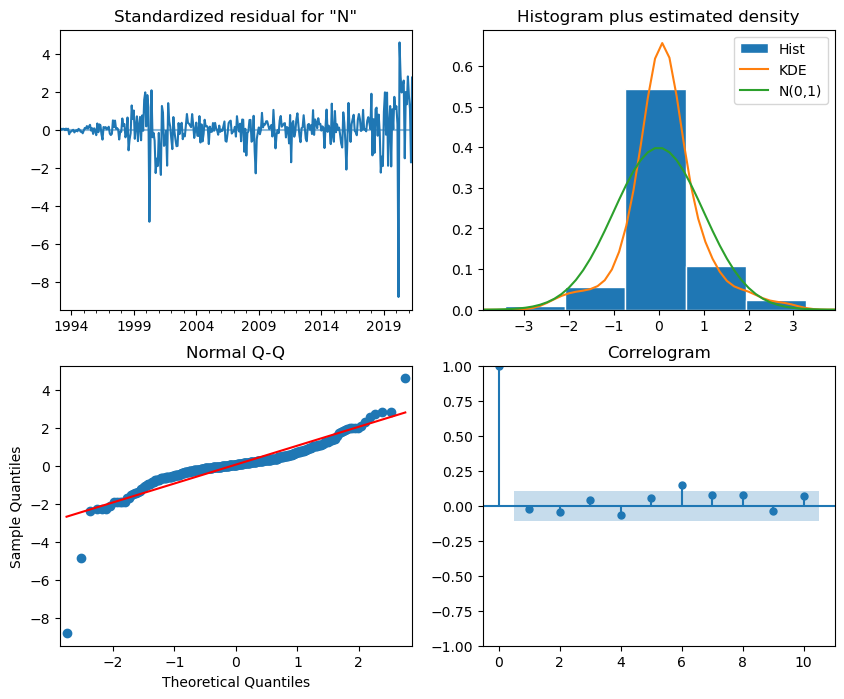

In [134]:
# model1 : d=1 D=0 #(1, 1, 2, 0, 0, 1)
result_df_SARIMA1 = SARMIA_M(train,orders, 1, 0 , s)
print(result_df_SARIMA1[:10], end='\n')
model_fit1 = train_models(train, order = (1,1,2), seasonal_order=(0,0,1,12))
check_residuals(model_fit1)
    
# model2 : d=1 D=1 #(1, 1, 2, 0, 1, 1)
result_df_SARIMA2 = SARMIA_M(train,orders, 1, 1, s)
print(result_df_SARIMA2[:10], end='\n')
model_fit2 = train_models(train, order = (1,1,2), seasonal_order=(0,1,1,12))
check_residuals(model_fit2)
    
# model3 : d=0 D=1 #(2, 0, 2, 0, 1, 2)
#Singular Matirx
#result_df_SARIMA3 = SARMIA_M(train,orders, 0, 1, s)
#print(result_df_SARIMA3[:10], end='\n')
#model_fit3 = train_models(train, order = (2,0,2), seasonal_order=(0,1,2,12))
#check_residuals(model_fit3)

In [135]:
arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=2, max_d=1, \
                         max_q= 2, start_P=0, D=1, start_Q=0, max_P=2, max_D= 1, \
                         max_Q=2, m=12, seasonal=True, error_action='warn', trace=True,\
                         supress_warning=True, stepwise=True, randomstate =1, n_fits=50)
arima_model.summary()    

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4771.133, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4669.397, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4624.812, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4750.372, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4626.071, Time=0.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4626.050, Time=1.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4669.311, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4633.565, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=4626.786, Time=0.69 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4624.993, Time=0.42 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=4624.107, Time=1.01 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=4753.509, Time=0.24 sec
 ARIMA(1,1,2)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  352
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2307.053
Date:                              Wed, 12 Jul 2023   AIC                           4624.107
Time:                                      20:30:37   BIC                           4643.237
Sample:                                  01-01-1992   HQIC                          4631.730
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9642      0.058    -16.664      0.000      -1.078      -0.851
ma.L1          1.1703      0.055     21.462      0.000       1.063       1.277
ma.L2          0.2428      0.023     10.521      0.000       0.198       0.288
ma.S.L12      -0.8238      0.042    -19.822      0.000      -0.905      -0.742
sigma2      4.603e+04   1253.815     36.711      0.000    4.36e+04    4.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              6222.66
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                            -2.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

      lb_stat  lb_pvalue
1    0.140877   0.707411
2    0.867737   0.647998
3    1.471161   0.688942
4    3.096377   0.541829
5    4.212645   0.519224
6   11.618509   0.071041
7   13.653467   0.057699
8   15.514709   0.049877
9   16.034741   0.066160
10  17.692575   0.060376
11  18.197351   0.077113


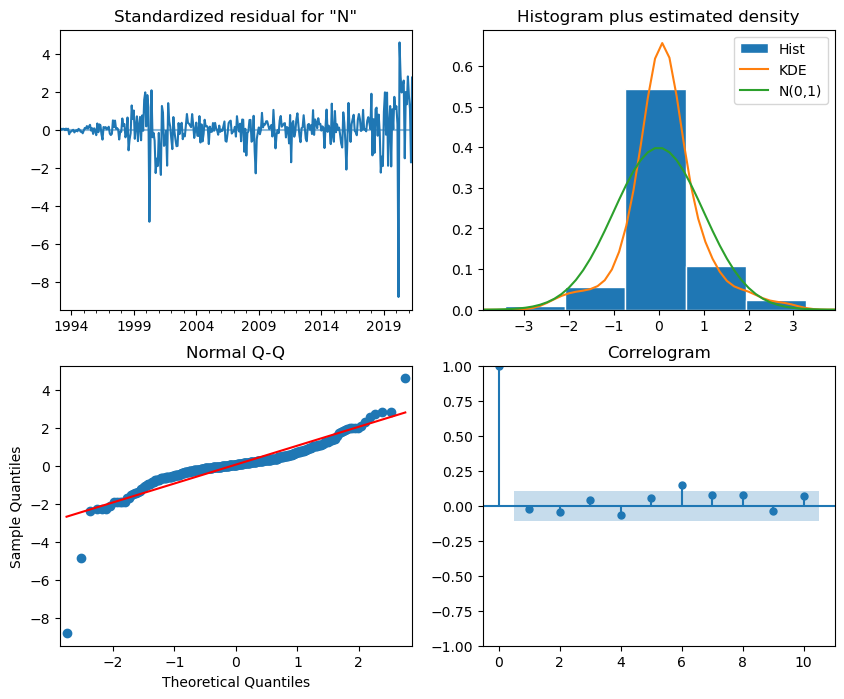

In [136]:
order = (1,1,2)
seasonal_order=(0,1,1,12)
model_fit_auto = train_models(train, order = order, seasonal_order=seasonal_order)
check_residuals(model_fit_auto)

### Prediction

In [137]:
def predict_TS(model_fit, order, seasonal_order, sep):
    if sep == 1:
        prediction = model_fit2.get_prediction(352, 376)
        prediction = prediction.predicted_mean
    elif sep==2:
        pred_SARIMA =[]
        for i in range(352, 376, 2):
            model_rol = SARIMAX(l_df[:i], order = order, seasonal_order= seasonal_order)
            model_fit_r = model_rol.fit(disp=False)
            prediction_r = model_fit_r.get_prediction(0, i+2 -1)
            pred = prediction_r.predicted_mean.iloc[-2:]
            pred_SARIMA.extend(pred)
        prediction = pd.DataFrame(pred_SARIMA, columns=['pred_NASDAQ'])
        prediction.set_index(test.index,inplace=True)
    else:
        pred_SARIMAX =[]
        for i in range(352, 376, 2):
            model_rol = SARIMAX(l_df[:i], exog_best[:i], order= order, seasonal_order= seasonal_order)
            model_fit_r = model_rol.fit(disp=False)
            prediction_r = model_fit_r.get_prediction(start =0, end= i+2 -1, exog=exog_best[i:i+2])
            pred = prediction_r.predicted_mean.iloc[-2:]
            pred_SARIMAX.extend(pred)
        prediction = pd.DataFrame(pred_SARIMAX, columns=['pred_NASDAQ'])
        prediction.set_index(test.index,inplace=True)
    
    plt.figure(figsize=(10,5))
    plt.plot(l_df, label = "actual_NASDAQ")
    plt.plot(prediction, label = "predicted NASDAQ")
    plt.legend()
    plt.show()
    
    return prediction

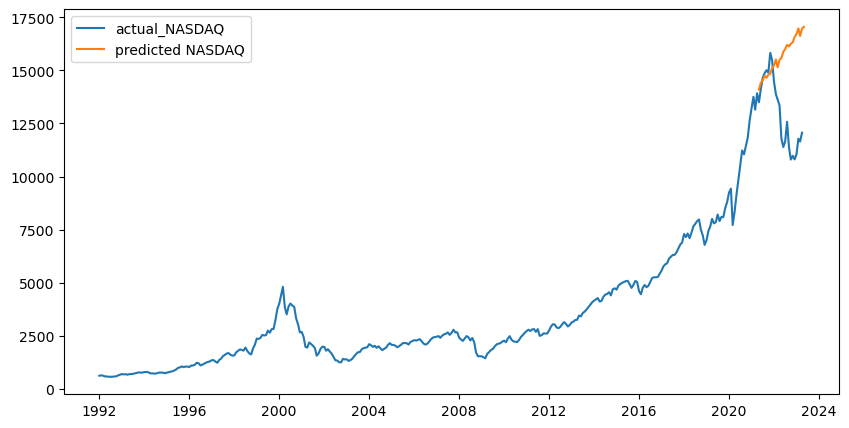

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\tsa\states

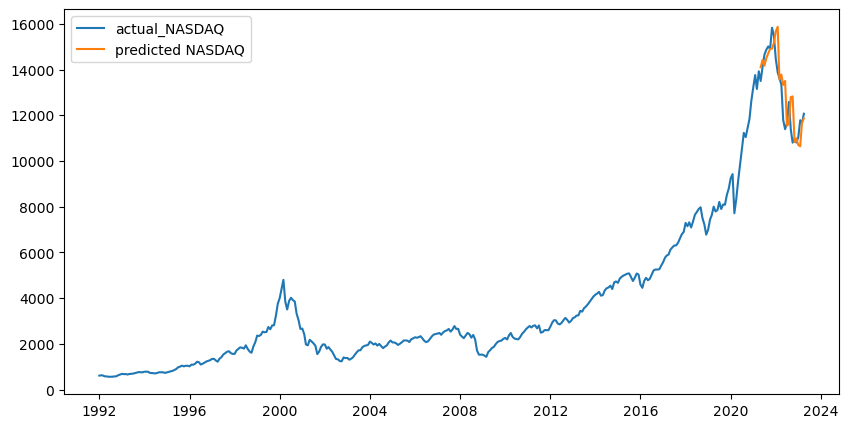

In [138]:
order = (1,1,2)
seasonal_order=(0,1,1,12)
# Prediction : seq1 = mean(), seq2 = rolling forecast, seq3= SARIMAX
prediction = predict_TS(model_fit2, order, seasonal_order, sep=1)
prediction = predict_TS(model_fit2, order, seasonal_order, sep=2)

### Evaluating Model

In [139]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [140]:
mape_SARIMA = mape(test, prediction['pred_NASDAQ'])
print('\nMean Absolute Percentage Error')
print(mape_SARIMA, end='\n\n')


Mean Absolute Percentage Error
5.737724274788118



# SARIMAX

In [141]:
#Exogenous variables and train
exog =c_df[['CoreCPIFood', 'CoreCPIFuel', 'CoreCPIHousing', 'CPI', 'GDP', 'DSPIC','FEDINT', 'PCE', 'POPUL', 'UnemploymentRates']]
exog_train = exog[:352]
    
#select parameters using auto_arima()
arima_modelX = auto_arima(train, exogenous=exog_train, start_p=0, d=1, start_q=0, max_p=3, max_d=3, \
                          max_q= 3, start_P=0, D=1, start_Q=0, max_P=3, max_D= 3, \
                          max_Q=3, m=12, seasonal=True, error_action='warn', trace=True,\
                          supress_warning=True, stepwise=True, randomstate =1, n_fits =50)
arima_modelX.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4771.133, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4669.397, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4624.812, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4750.372, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4626.071, Time=0.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4626.050, Time=1.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4669.311, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4633.565, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=4626.786, Time=0.69 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4624.993, Time=0.43 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=4624.107, Time=0.98 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=4753.509, Time=0.24 sec
 ARIMA(1,1,2)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  352
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2307.053
Date:                              Wed, 12 Jul 2023   AIC                           4624.107
Time:                                      20:31:11   BIC                           4643.237
Sample:                                  01-01-1992   HQIC                          4631.730
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9642      0.058    -16.664      0.000      -1.078      -0.851
ma.L1          1.1703      0.055     21.462      0.000       1.063       1.277
ma.L2          0.2428      0.023     10.521      0.000       0.198       0.288
ma.S.L12      -0.8238      0.042    -19.822      0.000      -0.905      -0.742
sigma2      4.603e+04   1253.815     36.711      0.000    4.36e+04    4.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              6222.66
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                            -2.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [142]:
def SARIAMX_model(exog, order, seasonal_order):
    exog_train = exog[:352]
    SARIMAX_model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order, simple_differencing=False)
    best_m = SARIMAX_model.fit(disp=False)
    print(best_m.summary())

In [143]:
order = (0,1,1) 
seasonal_order=(0,1,1,12)
    
    
#SARIMAX with all exogenous variables
SARIAMX_model(exog, order, seasonal_order)
    
#Select exogenous variables
exog_d =c_df[['CoreCPIFood', 'CoreCPIFuel', 'CoreCPIHousing', 'CPI', 'GDP', 'DSPIC','FEDINT', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)
exog_d =c_df[['CoreCPIFood', 'CoreCPIFuel', 'CoreCPIHousing', 'CPI', 'GDP', 'DSPIC', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)
exog_d =c_df[['CoreCPIFood','CoreCPIHousing', 'CPI', 'GDP', 'DSPIC', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)
exog_d =c_df[['CoreCPIHousing', 'CPI', 'GDP', 'DSPIC', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)
exog_d =c_df[['CoreCPIHousing', 'CPI', 'DSPIC', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)
exog_d =c_df[['CPI', 'DSPIC', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)
exog_d =c_df[['DSPIC', 'PCE', 'UnemploymentRates']]
SARIAMX_model(exog_d, order, seasonal_order)

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             NASDAQ   No. Observations:                  352
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2277.037
Date:                            Wed, 12 Jul 2023   AIC                           4580.075
Time:                                    20:31:13   BIC                           4629.813
Sample:                                01-01-1992   HQIC                          4599.896
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CoreCPIFood         -29.8888     26.016     -1.149      0.251     -80.880      21.103
CoreCPIFuel   

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             NASDAQ   No. Observations:                  352
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2277.053
Date:                            Wed, 12 Jul 2023   AIC                           4578.105
Time:                                    20:31:15   BIC                           4624.017
Sample:                                01-01-1992   HQIC                          4596.401
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CoreCPIFood         -29.8845     25.833     -1.157      0.247     -80.515      20.746
CoreCPIFuel   

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             NASDAQ   No. Observations:                  352
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2276.795
Date:                            Wed, 12 Jul 2023   AIC                           4575.590
Time:                                    20:31:17   BIC                           4617.676
Sample:                                01-01-1992   HQIC                          4592.361
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CoreCPIFood         -20.5097     26.279     -0.780      0.435     -72.015      30.996
CoreCPIFuel   

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             NASDAQ   No. Observations:                  352
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2276.006
Date:                            Wed, 12 Jul 2023   AIC                           4570.012
Time:                                    20:31:20   BIC                           4604.446
Sample:                                01-01-1992   HQIC                          4583.734
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CoreCPIHousing      -50.1826     46.198     -1.086      0.277    -140.728      40.363
CPI           

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             NASDAQ   No. Observations:                  352
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2276.308
Date:                            Wed, 12 Jul 2023   AIC                           4568.617
Time:                                    20:31:22   BIC                           4599.225
Sample:                                01-01-1992   HQIC                          4580.814
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CoreCPIHousing      -50.1386     47.313     -1.060      0.289    -142.870      42.593
CPI           

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             NASDAQ   No. Observations:                  352
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2276.768
Date:                            Wed, 12 Jul 2023   AIC                           4567.537
Time:                                    20:31:23   BIC                           4594.319
Sample:                                01-01-1992   HQIC                          4578.209
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CPI                  35.2367     21.469      1.641      0.101      -6.842      77.315
DSPIC         

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     lb_stat  lb_pvalue
1   0.048085   0.826429
2   1.324369   0.515724
3   1.391744   0.707471
4   1.474534   0.831143
5   1.590389   0.902409
6   4.618369   0.593605
7   5.103225   0.647368
8   5.607987   0.691049
9   5.683801   0.771100
10  5.879480   0.825285
11  5.879679   0.881270


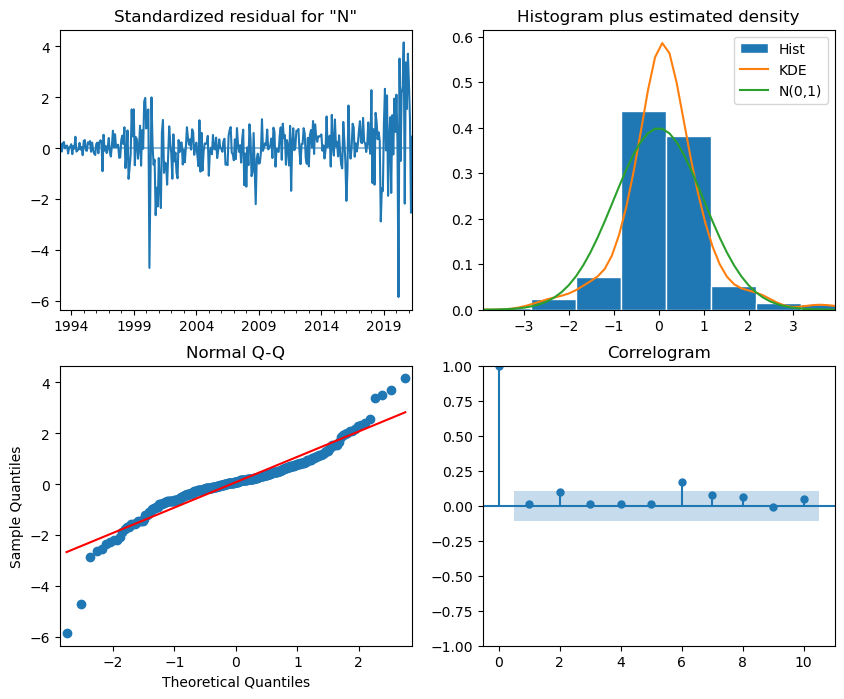

In [144]:
#Selecting best model
exog_best =exog[['DSPIC','PCE', 'UnemploymentRates']]
SARIMAX_model = SARIMAX(train, exog_d[:352], order=order, seasonal_order=seasonal_order, simple_differencing=False)
best_m = SARIMAX_model.fit(disp=False)
    
#examining Residuals 
check_residuals(best_m)   

C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\singg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

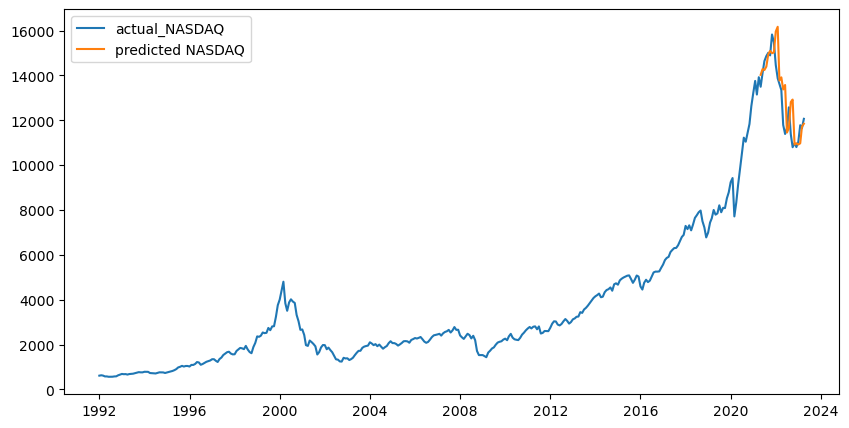




Mean Absolute Percentage Error for SARIMAX
5.820710562853496



In [145]:
#Prediction Time Series and Evaluating models
prediction = predict_TS(best_m, order, seasonal_order, 3)
mape_SARIMAX = mape(test, prediction['pred_NASDAQ'])
print('\n\n\nMean Absolute Percentage Error for SARIMAX')
print(mape_SARIMAX,end='\n\n') 

### Reference

Marco Peixeiro, Oct. 2022, Time Series Forecasting in Python, Manning Publications, https://learning.oreilly.com/library/view/time-series-forecasting/9781617299889/
